# Q Function
* used to approximate the reward based on a state
* Q(s,a) calculates the expected future value from state **s** and action **a**
* in DQN, we use a **neural network to approximate the reward**

# Classes
* Environment
* Agent
* Runner

## Environment

In [1]:
class Action:
    def __init__(self, act, days, percentage):
        self.act = act
        self.days = days
        self.percentage = percentage

In [61]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime

BUY = 'buy'
SELL = 'sell'
SKIP = 'skip'

class Environment:
    
    min_days_to_hold = 5
    max_days_to_hold = 10
    
    def __init__(self, 
                 ticker, 
                 initial_deposit = 100000,
                 from_date = datetime.datetime(2007, 1, 1), 
                 to_date = datetime.datetime(2017, 1, 1),
                 window = 20):
        self.initial_deposit = initial_deposit
        self.window = window
        self.data = pdr.get_data_google(ticker, from_date, to_date)
        self.pct_data = self.data.pct_change().fillna(0)
        self.data_length = len(self.data)
        
        actions = np.array([BUY, SELL, SKIP])
        days_to_holds = np.arange(Environment.min_days_to_hold, 
                                  Environment.max_days_to_hold + 1,
                                  1)
        
        self.action_space = [Action(act, days, 3) for act in actions for days in days_to_holds]
        self.reset()
        
    def reset(self):
        self.deposit = self.initial_deposit
        self.current_index = self.window
        self.actions = {}
        
        return self.state()
    
    def score(self):
        return self.deposit
    
    def enough_data_provided(self):
        return self.current_index + Environment.max_days_to_hold <= self.data_length
    
    def state(self):
        return self.pct_data.iloc[self.current_index - self.window:self.current_index]['Close']
    
    # def price_state(self):
    #    return self.data.iloc[self.current_index - self.window:self.current_index]['Close']
        
    def state_size(self):
        return self.window
    
    def action_size(self):
        return len(self.action_space)
        
    def step(self, action_idx: int):
        action = self.action_space[action_idx]
        #print('\t=> current action is: {} at {}'.format(action, self.data.index[self.current_index]))
        
        df = self.data.iloc[self.current_index: self.current_index + action.days]
        on_date = df.index[0]
        first_day_price = df.iloc[0]['Close']
        last_day_price = df.iloc[-1]['Close']
        
        if action.act == BUY:
            reward = last_day_price - first_day_price
        elif action.act == SELL:
            reward = first_day_price - last_day_price
        elif action.act == SKIP:
            reward = 0
            
        self.actions[on_date] = (action, reward)
        
        self.current_index += action.days
        self.deposit += reward * (self.deposit*action.percentage/100)
        
        next_state = self.state()
        done = False
        _ = None
        return next_state, reward, done, _ 

## Agent

In [3]:
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import mean_squared_error

class Agent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.99
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
    
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(36, input_dim=self.state_size, activation='relu'))
        model.add(Dense(18, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=mean_squared_error,
                      optimizer=Adam(lr=self.learning_rate))
        return model
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                a = self.model.predict(next_state)[0]
                t = self.target_model.predict(next_state)[0]
                target[0][action] = reward + self.gamma * t[np.argmax(a)]
            self.model.fit(state, target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

Using TensorFlow backend.


## Runner

In [4]:
env = Environment('AAPL')
state_size = env.state_size()
action_size = env.action_size()
print('Action size: {}, state size: {}'.format(action_size, state_size))

Action size: 15, state size: 20


In [5]:
agent = Agent(state_size, action_size)
EPISODES = 500
batch_size = 32

In [6]:
max_reward = None
for e in range(EPISODES):
    state = env.reset()
    state = state.values.reshape([1, state_size])
    while env.enough_data_provided():
        action_idx = agent.act(state)
        next_state, reward, done, _ = env.step(action_idx) # build these parameters into the NN model
        # reward = reward if not done else -10
        next_state = next_state.values.reshape([1, state_size])
        agent.remember(state, action_idx, reward, next_state, done)
        state = next_state
    
    if max_reward is None or max_reward[0] < env.score():
        max_reward = (env.score(), env.actions)
    
    agent.update_target_model()
    print("episode: {}/{}, score: {}, e: {:.2}".format(e, EPISODES, env.score(), agent.epsilon))
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)
print(max_reward)

episode: 0/500, score: 5822.160844845312, e: 1.0
episode: 1/500, score: 47791.39638356209, e: 0.99
episode: 2/500, score: 859137.4077476239, e: 0.98
episode: 3/500, score: 48503.41733107561, e: 0.97
episode: 4/500, score: 83329.94853865087, e: 0.96
episode: 5/500, score: 75498.00394796302, e: 0.95
episode: 6/500, score: 82316.16798564426, e: 0.94
episode: 7/500, score: 7176.9721024450555, e: 0.93
episode: 8/500, score: 232752.05095765693, e: 0.92
episode: 9/500, score: 43505.46217392056, e: 0.91
episode: 10/500, score: 41839.26145666254, e: 0.9
episode: 11/500, score: 83453.2727221593, e: 0.9
episode: 12/500, score: 68212.55678993631, e: 0.89
episode: 13/500, score: 200235.52120640484, e: 0.88
episode: 14/500, score: 54848.88173651335, e: 0.87
episode: 15/500, score: 52226.68767160795, e: 0.86
episode: 16/500, score: 9984.133457158414, e: 0.85
episode: 17/500, score: 30235.0298211429, e: 0.84
episode: 18/500, score: 112466.18758673618, e: 0.83
episode: 19/500, score: 1602606.3689595526

episode: 159/500, score: 261023.3674608978, e: 0.2
episode: 160/500, score: 860152.4168343699, e: 0.2
episode: 161/500, score: 462702.7973840511, e: 0.2
episode: 162/500, score: 475105.0054852209, e: 0.2
episode: 163/500, score: 428799.7786401746, e: 0.19
episode: 164/500, score: 53701.8534092534, e: 0.19
episode: 165/500, score: 204734.9075348067, e: 0.19
episode: 166/500, score: 580753.3555514412, e: 0.19
episode: 167/500, score: 104723.26201759929, e: 0.19
episode: 168/500, score: 275156.5224914343, e: 0.18
episode: 169/500, score: 448946.9136717896, e: 0.18
episode: 170/500, score: 417830.0480538676, e: 0.18
episode: 171/500, score: 369097.5440674706, e: 0.18
episode: 172/500, score: 698457.3068292165, e: 0.18
episode: 173/500, score: 130646.96717403506, e: 0.18
episode: 174/500, score: 629546.5471209997, e: 0.17
episode: 175/500, score: 297745.88303540164, e: 0.17
episode: 176/500, score: 113509.24713805925, e: 0.17
episode: 177/500, score: 300504.80031979573, e: 0.17
episode: 178

episode: 315/500, score: 1187760.4687652008, e: 0.05
episode: 316/500, score: 285276.335672143, e: 0.05
episode: 317/500, score: 215441.2970557708, e: 0.05
episode: 318/500, score: 167816.88326879463, e: 0.05
episode: 319/500, score: 165745.43370293768, e: 0.05
episode: 320/500, score: 404024.5872110892, e: 0.05
episode: 321/500, score: 267481.20356724155, e: 0.05
episode: 322/500, score: 572855.9063094258, e: 0.05
episode: 323/500, score: 288254.3376071631, e: 0.05
episode: 324/500, score: 375757.70695063897, e: 0.05
episode: 325/500, score: 113399.56399551718, e: 0.05
episode: 326/500, score: 1503533.360753903, e: 0.05
episode: 327/500, score: 140413.41734068256, e: 0.05
episode: 328/500, score: 119924.31122392294, e: 0.05
episode: 329/500, score: 328036.110368658, e: 0.05
episode: 330/500, score: 46924.02633364915, e: 0.05
episode: 331/500, score: 1602524.514172385, e: 0.05
episode: 332/500, score: 131324.43864739256, e: 0.05
episode: 333/500, score: 217362.5247773279, e: 0.05
episo

episode: 472/500, score: 406682.0198604959, e: 0.05
episode: 473/500, score: 104482.69539459464, e: 0.05
episode: 474/500, score: 115224.79833067881, e: 0.05
episode: 475/500, score: 263105.1836702969, e: 0.05
episode: 476/500, score: 134744.7842564476, e: 0.05
episode: 477/500, score: 351612.0730765403, e: 0.05
episode: 478/500, score: 372805.4760478465, e: 0.05
episode: 479/500, score: 407216.57176467974, e: 0.05
episode: 480/500, score: 135068.76454245902, e: 0.05
episode: 481/500, score: 259528.25167396173, e: 0.05
episode: 482/500, score: 345931.5718413376, e: 0.05
episode: 483/500, score: 247551.5630519909, e: 0.05
episode: 484/500, score: 458826.095351203, e: 0.05
episode: 485/500, score: 181164.09995983922, e: 0.05
episode: 486/500, score: 749776.8544402746, e: 0.05
episode: 487/500, score: 353295.86693231366, e: 0.05
episode: 488/500, score: 205237.02610358788, e: 0.05
episode: 489/500, score: 133800.08218074302, e: 0.05
episode: 490/500, score: 395450.7000523777, e: 0.05
epis

(3480852.7167761987, {Timestamp('2007-02-01 00:00:00'): (<__main__.Action object at 0x00000210FB12DCC0>, 0.20000000000000107), Timestamp('2007-02-08 00:00:00'): (<__main__.Action object at 0x00000210FB12DCC0>, -0.12000000000000099), Timestamp('2007-02-15 00:00:00'): (<__main__.Action object at 0x00000210FB12DCC0>, 0.61999999999999922), Timestamp('2007-02-23 00:00:00'): (<__main__.Action object at 0x00000210FB12DCC0>, -0.28000000000000114), Timestamp('2007-03-02 00:00:00'): (<__main__.Action object at 0x00000210FB12DCC0>, 0.37000000000000099), Timestamp('2007-03-09 00:00:00'): (<__main__.Action object at 0x00000210FB12DCC0>, 0.23000000000000043), Timestamp('2007-03-16 00:00:00'): (<__main__.Action object at 0x00000210FB12DCC0>, 0.61999999999999922), Timestamp('2007-03-23 00:00:00'): (<__main__.Action object at 0x00000210FB12DCC0>, 0.030000000000001137), Timestamp('2007-03-30 00:00:00'): (<__main__.Action object at 0x00000210FB12DCC0>, 0.25999999999999979), Timestamp('2007-04-09 00:00:00

In [82]:
signals = np.array([[], [], []]).T
signals.shape

(0, 3)

In [84]:
for key, value in max_reward[1].items():
    print('Date: {} => Action: {} => Reward: {}'.format(key, value[0].act, value[1]))
    signals = np.concatenate((signals, np.array([[key, value[0].act, env.data.loc[key]['Close']]])), axis = 0)

Date: 2007-02-01 00:00:00 => Action: buy => Reward: 0.20000000000000107
Date: 2007-02-08 00:00:00 => Action: buy => Reward: -0.120000000000001
Date: 2007-02-15 00:00:00 => Action: buy => Reward: 0.6199999999999992
Date: 2007-02-23 00:00:00 => Action: buy => Reward: -0.28000000000000114
Date: 2007-03-02 00:00:00 => Action: buy => Reward: 0.370000000000001
Date: 2007-03-09 00:00:00 => Action: buy => Reward: 0.23000000000000043
Date: 2007-03-16 00:00:00 => Action: buy => Reward: 0.6199999999999992
Date: 2007-03-23 00:00:00 => Action: buy => Reward: 0.030000000000001137
Date: 2007-03-30 00:00:00 => Action: buy => Reward: 0.2599999999999998
Date: 2007-04-09 00:00:00 => Action: buy => Reward: -0.4900000000000002
Date: 2007-04-16 00:00:00 => Action: buy => Reward: -0.0600000000000005
Date: 2007-04-23 00:00:00 => Action: buy => Reward: 0.9100000000000001
Date: 2007-04-30 00:00:00 => Action: buy => Reward: 0.14000000000000057
Date: 2007-05-07 00:00:00 => Action: buy => Reward: 0.679999999999999

In [85]:
signals.shape

(505, 3)

In [86]:
signals_df = pd.DataFrame(signals)

In [87]:
signals_df.set_index(keys = [0], inplace=True)

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

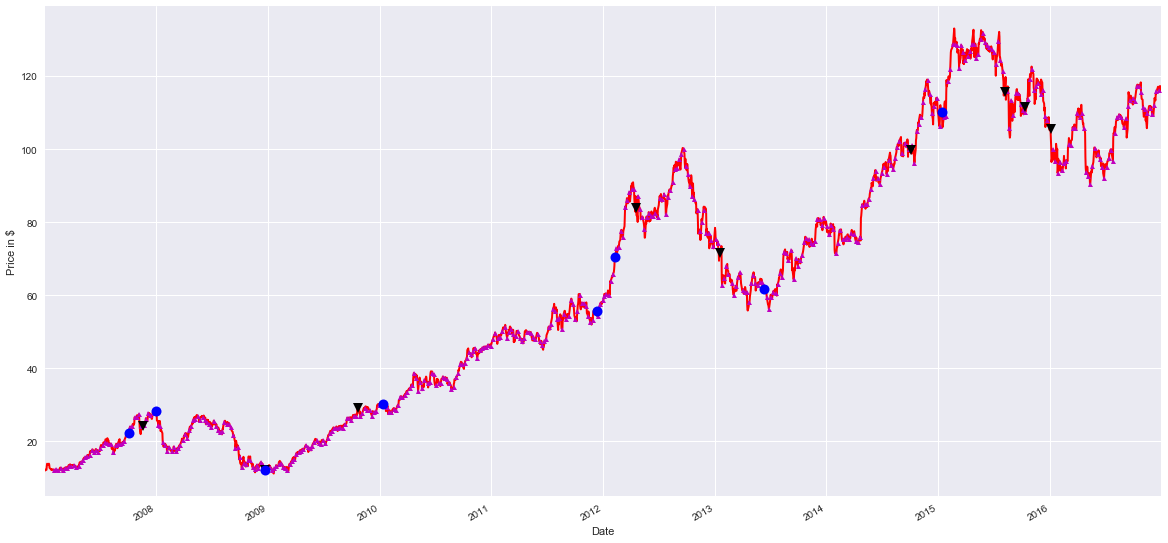

In [96]:
fig = plt.figure(figsize=(20,10))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
env.data['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the buy signals
ax1.plot(signals_df.loc[signals_df[1] == 'buy'].index, 
         signals_df.loc[signals_df[1] == 'buy'][2],
         '^', markersize=5, color='m')

ax1.plot(signals_df.loc[signals_df[1] == 'sell'].index, 
         signals_df.loc[signals_df[1] == 'sell'][2],
         'v', markersize=10, color='k')

ax1.plot(signals_df.loc[signals_df[1] == 'skip'].index, 
         signals_df.loc[signals_df[1] == 'skip'][2],
         'o', markersize=10, color='b')
                  
# Show the plot
plt.show()